In [218]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.metrics import pairwise_distances

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True

In [80]:
def read_xy(x_fp, y_fp):
    x = pd.read_csv(x_fp, header=None, index_col=0)
    y = pd.read_csv(y_fp, index_col=0)
    return {'x': x, 'y': y}

In [85]:
def count_y_class(y_df):
    y_class = y_df.apply(lambda x: ''.join([str(i) for i in x]), axis=1).to_frame(name='class')
    # y_class.head(2)
    
    y_class2num = y_class['class'].value_counts().to_frame(name='num')
    y_class2num['n_error'] = 0
    return y_class2num

In [87]:
def predict_y(x, model):
    y_pred_raw = model.predict(x)
    y_pred_bool = tf.math.sigmoid(y_pred_raw)
    y_pred_bool = y_pred_bool.numpy()
    y_pred_bool[y_pred_bool >= 0.5] = 1
    y_pred_bool[y_pred_bool < 0.5] = 0
    return y_pred_bool

In [89]:
def count_pred_error_in_class(y, y_pred):
    pred_comp_bool = np.all(y == y_pred, axis=1)
    y_pred_error = y_pred[~pred_comp_bool]
    y_class = y.apply(lambda x: ''.join([str(i) for i in x]), axis=1).to_frame(name='class')
    y_pred_error_count_by_class = y_class.loc[y_class.index.isin(y_pred_error.index), 'class'].value_counts().to_frame(name='n_error')
    
    y_class2num = y_class['class'].value_counts().to_frame(name='num')
    y_class2num['n_error'] = 0
    y_class2num.loc[y_pred_error_count_by_class.index, 'n_error'] = y_pred_error_count_by_class.n_error
    return y_class2num

In [81]:
model = keras.models.load_model('../big-data/moses_dataset/nn/model.h5')

In [82]:
xy_train = read_xy(x_fp='../big-data/moses_dataset/nn/x_training_set_mol2vec.csv', y_fp='../big-data/moses_dataset/nn/y_train.csv')
x_train = xy_train['x']
y_train = xy_train['y']

In [83]:
x_train.head(2)

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,,,,,,,,,,,,,,,,,,,,,
id6,0.230,4.271,-1.860,3.139,2.185,2.498,2.318,1.343,-0.212,1.851,...,7.804,1.818,0.267,3.757,-0.121,3.140,1.682,-2.240,-0.015,-1.227
id8,0.256,8.870,0.412,2.352,3.176,6.292,0.904,1.206,-0.017,-0.431,...,9.534,2.898,2.562,2.606,0.781,3.915,-3.332,-2.733,1.892,-2.017


In [84]:
y_train.head(2)

,nN,nS,nO,nX,nBondsD,nBondsT,naRing,nARing
0,,,,,,,,
id6,1,0,1,1,1,0,1,1
id8,0,0,1,0,1,0,1,0


In [86]:
y_train_class2num = count_y_class(y_df=y_train)
y_train_class2num.head(2)

,num,n_error
11000010,4500,0
10110011,4500,0


In [88]:
y_train_pred_bool = predict_y(x=x_train, model=model)
y_train_pred = pd.DataFrame(data=y_train_pred_bool, index=y_train.index, columns=y_train.columns)
y_train_pred.head(2)

,nN,nS,nO,nX,nBondsD,nBondsT,naRing,nARing
0,,,,,,,,
id6,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
id8,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [90]:
y_train_class2num2 = count_pred_error_in_class(y=y_train, y_pred=y_train_pred)
y_train_class2num2.head()

,num,n_error
11000010,4500,74
10110011,4500,49
10010010,4500,15
11101001,4500,2104
11100011,4500,108


In [91]:
y_train_class2num2.sum()

num        155970
n_error      8554
dtype: int64

### test

In [92]:
xy_test = read_xy(x_fp='../big-data/moses_dataset/nn/x_test_set_mol2vec.csv', y_fp='../big-data/moses_dataset/nn/y_test.csv')
x_test = xy_test['x']
y_test = xy_test['y']

In [93]:
x_test.head(2)

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,,,,,,,,,,,,,,,,,,,,,
id27,0.794,7.313,-1.258,2.849,2.937,3.976,1.416,1.870,0.279,1.028,...,10.392,2.231,1.297,3.920,-0.440,4.393,0.002,-3.069,0.695,-1.967
id39,1.467,3.095,-2.830,2.447,2.140,1.325,2.328,1.323,-0.670,2.027,...,7.120,1.221,0.689,4.305,-0.615,4.696,2.862,-1.267,-0.731,-1.225


In [94]:
y_test.head(2)

,nN,nS,nO,nX,nBondsD,nBondsT,naRing,nARing
0,,,,,,,,
id27,0,0,1,0,1,0,1,0
id39,1,0,1,0,1,1,1,1


In [96]:
y_test_pred = predict_y(x=x_test, model=model)
y_test_pred = pd.DataFrame(data=y_test_pred, index=y_test.index, columns=y_test.columns)
y_test_pred.head(2)

,nN,nS,nO,nX,nBondsD,nBondsT,naRing,nARing
0,,,,,,,,
id27,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
id39,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0


In [97]:
y_test_class2num = count_pred_error_in_class(y=y_test, y_pred=y_test_pred)
y_test_class2num.head()

,num,n_error
10111111,5000,2227
11101010,5000,570
10101111,5000,1280
10101010,5000,345
11000011,3826,717


In [98]:
y_test_class2num.sum()

num        48207
n_error     7821
dtype: int64

In [99]:
7821 / 48207

0.16223784927500157

In [101]:
y_test_class2num['class_in_train'] = 0
y_test_class2num.loc[y_test_class2num.index.isin(y_train_class2num2.index), 'class_in_train'] = 1

In [105]:
y_test_class2num['accuray_in_each_class'] = 1 - y_test_class2num['n_error'] / y_test_class2num['num']

In [106]:
y_test_class2num.head()

,num,n_error,class_in_train,accuray_in_each_class
10111111,5000,2227,0,0.554600
11101010,5000,570,0,0.886000
10101111,5000,1280,0,0.744000
10101010,5000,345,0,0.931000
11000011,3826,717,0,0.812598


In [107]:
y_test_class2num.to_csv('../big-data/moses_dataset/nn/y_test_class2num.csv')

### embedding vector

In [108]:
m_part1 = keras.models.load_model('../big-data/moses_dataset/nn/m_part1.h5')
m_part1

In [109]:
x_train_test = x_train.append(x_test)
x_train_test.shape

(204177, 100)

In [118]:
x_embedding = m_part1.predict(x_train_test)
type(x_embedding)

numpy.ndarray

In [119]:
x_embedding = pd.DataFrame(data=x_embedding, index=x_train_test.index)
x_embedding.head(2)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,,,,,,,,,,,,,,,,,,,,,
id6,0.0,67.581932,4.033874,0.000000,0.000000,0.000000,0.000000,0.020211,1.418569,0.906741,...,6.702059,0.000000,0.0,0.0,0.000000,0.0,1.863779,2.241956,0.0,0.000000
id8,0.0,80.029938,0.121835,6.874247,2.472669,0.980489,1.512571,0.000000,0.987258,2.906722,...,10.012863,6.625997,0.0,0.0,0.135132,0.0,2.963767,3.289106,0.0,1.881185


##### fragment embedding

In [245]:
frag2vec = pd.read_csv('../big-data/moses_dataset/best_model/sub_ws_4_minn_1_maxn_2/frag2vec_ws_4_minn_1_maxn_2.csv', index_col='fragment')
frag2vec.head(2)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
fragment,,,,,,,,,,,,,,,,,,,,,
CC,0.102366,0.236778,-0.212418,0.097849,0.353949,0.066136,0.251520,0.141767,-0.135168,0.230127,...,0.707791,-0.000694,-0.055997,0.399240,-0.149455,0.417486,0.369599,-0.189464,-0.133221,0.059110
CN,0.135850,0.226165,-0.434924,0.303119,-0.014223,0.132242,0.368385,0.068198,-0.059371,0.287510,...,0.617289,-0.113810,0.043899,0.385367,0.093859,0.156435,0.381115,-0.142981,0.027194,-0.063204


In [246]:
frag_embedding = m_part1.predict(frag2vec)
frag_embedding_df = pd.DataFrame(data=frag_embedding, index=frag2vec.index)
frag_embedding_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
fragment,,,,,,,,,,,,,,,,,,,,,
CC,0.879899,4.766980,0.484570,0.553562,0.671363,1.946618,1.211061,0.049551,0.000000,1.383978,...,0.0,1.430827,0.243160,0.453422,0.064221,0.418074,0.0,0.0,0.898957,1.974412
CN,0.949461,6.582223,0.017192,0.474302,0.457786,1.783010,1.694302,0.413362,0.393079,0.391579,...,0.0,1.946342,0.459903,0.213545,0.094952,0.602006,0.0,0.0,1.062216,1.731344


In [247]:
frag_embedding_df.to_csv('../big-data/moses_dataset/nn/frag_embedding.csv')

In [120]:
cid2smiles = pd.read_csv('../big-data/moses_dataset/result/mol2md_with_cid.csv', index_col='cid', usecols=['smiles', 'cid'])
cid2smiles.head(2)

,smiles
cid,
id2,CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1
id3,CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1ccnc1


In [192]:
cid2smiles.loc[x_embedding.index, ['smiles']].to_csv('../big-data/moses_dataset/nn/cid2smiles_all_in_train_test.csv')

In [208]:
x_embedding2 = x_embedding.copy()
x_embedding2['smiles'] = cid2smiles.loc[x_embedding.index, 'smiles']
x_embedding2.set_index('smiles', inplace=True)
# x_embedding.drop(columns='cid', inplace=True)
x_embedding2.head(2)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
smiles,,,,,,,,,,,,,,,,,,,,,
CC1Oc2ccc(Cl)cc2N(CC(O)CO)C1=O,0.0,67.581932,4.033874,0.000000,0.000000,0.000000,0.000000,0.020211,1.418569,0.906741,...,6.702059,0.000000,0.0,0.0,0.000000,0.0,1.863779,2.241956,0.0,0.000000
COc1ccccc1OC(=O)Oc1ccccc1OC,0.0,80.029938,0.121835,6.874247,2.472669,0.980489,1.512571,0.000000,0.987258,2.906722,...,10.012863,6.625997,0.0,0.0,0.135132,0.0,2.963767,3.289106,0.0,1.881185


In [209]:
x_embedding2.iloc[9, :].name

'Cc1cc(Cc2cnc(N)nc2N)c2cccnc2c1N(C)C'

In [154]:
def cal_distance(x, y, metric='euclidean'):
    if type(x) == pd.core.series.Series:
        x = x.values.reshape(1, -1)
    if type(y) == pd.core.series.Series:
        y = y.values.reshape(1, -1)
    return pairwise_distances(x, y, metric=metric)

In [251]:
def print_closest_words(x_embedding, x_query, n=5, add_vec=None):
    x = x_embedding.loc[x_query].values.reshape(1, -1).copy()
    # print('x is: {}'.format(x))
    if add_vec is not None:
        x += add_vec
        # print('x + add_vec is: {}'.format(x))
    dists = cal_distance(x=x_embedding.values, y=x)     # compute distances to all words
    lst = sorted(enumerate(dists), key=lambda x: x[1]) # sort by distance
    # print(lst[:100])
    if add_vec is not None:
        for idx, difference in lst[0:n]:
            print(x_embedding.iloc[idx,:].name, difference)
    else:
        for idx, difference in lst[1:n+1]:   # take the top n
            print(x_embedding.iloc[idx,:].name, difference)

In [182]:
def get_minus_result(x_embedding, x, y):
    x = x_embedding.loc[x].values.reshape(1, -1)
    y = x_embedding.loc[y].values.reshape(1, -1)
    return x-y

In [180]:
mol1 = x_embedding2.loc['COc1ccccc1OC(=O)Oc1ccccc1OC']
mol2 = x_embedding2.loc['CC1Oc2ccc(Cl)cc2N(CC(O)CO)C1=O']
# mol1 = mol1.values.reshape(-1,1)
# print(mol1.shape, type(mol1))
# print(type(mol1) == pd.core.series.Series)
cal_distance(mol1, mol2)

array([[17.525618]], dtype=float32)

In [204]:
ch2 = get_minus_result(x_embedding2, 'COc1cccc(COC(=O)c2cccc(OC)c2O)c1', 'COc1ccccc1OC(=O)Oc1ccccc1OC')
ch2

array([[ 0.        ,  1.5102386 , -0.12183534, -0.03230286,  0.1806202 ,
         0.9449151 , -0.31577134,  0.        , -0.32957083,  0.71452665,
         0.5189152 ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.55741787,  0.        ,  0.46140313,  0.        , -0.2015264 ,
        -0.08266449,  0.42657948,  0.        ,  0.        ,  0.18944024,
         0.        ,  0.43624997, -0.03424692,  0.        , -0.05685472]],
      dtype=float32)

In [189]:
x_embedding2.loc['COc1ccccc1OC(=O)Oc1ccccc1OC'].values.reshape(1,-1)

array([[ 0.        , 80.02994   ,  0.12183534,  6.8742466 ,  2.4726686 ,
         0.98048943,  1.5125712 ,  0.        ,  0.9872577 ,  2.9067218 ,
        11.04242   ,  0.        ,  0.        ,  0.        ,  0.        ,
        14.450691  ,  0.        ,  2.153011  ,  0.        ,  2.9999425 ,
        10.012863  ,  6.6259966 ,  0.        ,  0.        ,  0.13513215,
         0.        ,  2.9637668 ,  3.2891064 ,  0.        ,  1.8811848 ]],
      dtype=float32)

In [181]:
print_closest_words(x_embedding=x_embedding2, x_query='COc1ccccc1OC(=O)Oc1ccccc1OC')

COc1ccccc1OC(=O)C(C)Oc1ccccc1 [2.100969]
COc1ccc(OC(=O)C(C)Oc2ccccc2)cc1 [2.1009717]
COC(=O)c1c(O)cc(OC)cc1OCc1ccccc1 [2.2790298]
COc1cccc(COC(=O)c2cccc(OC)c2O)c1 [2.2790298]
COc1ccc(OCCOC(=O)c2ccc(O)cc2)cc1 [2.2790298]


In [214]:
print_closest_words(x_embedding=x_embedding2, x_query='COC(=O)c1cc(Br)cc(Br)c1O')

x is: [[ 0.         54.23305     2.8906772   0.          0.73192406  1.6375101
   0.66602534  0.          1.0117786   3.3028266   8.843242    0.
   0.          0.          0.         13.1444845   0.          3.6800406
   0.          0.          6.5596437   5.708664    0.          0.
   0.          0.          3.63397     2.1773548   1.6543721   0.        ]]
COC(=O)c1cc(Br)c(O)c(Br)c1 [0.]
COc1c(Br)cc(C(C)=O)cc1Br [1.5614587]
CC(=O)Oc1cc(Br)c(C)cc1Br [1.5614587]
CC(=O)c1cc(Br)c(O)c(Br)c1O [1.5614587]
CC(=O)Oc1c(Br)cc(C)cc1Br [1.5614587]


In [215]:
print_closest_words(x_embedding=x_embedding2, x_query='COC(=O)c1cc(Br)cc(Br)c1O', add_vec=ch2)

x is: [[ 0.         54.23305     2.8906772   0.          0.73192406  1.6375101
   0.66602534  0.          1.0117786   3.3028266   8.843242    0.
   0.          0.          0.         13.1444845   0.          3.6800406
   0.          0.          6.5596437   5.708664    0.          0.
   0.          0.          3.63397     2.1773548   1.6543721   0.        ]]
x + add_vec is: [[ 0.0000000e+00  5.5743290e+01  2.7688420e+00 -3.2302856e-02
   9.1254425e-01  2.5824251e+00  3.5025400e-01  0.0000000e+00
   6.8220776e-01  4.0173531e+00  9.3621569e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  1.3701902e+01
   0.0000000e+00  4.1414437e+00  0.0000000e+00 -2.0152640e-01
   6.4769793e+00  6.1352434e+00  0.0000000e+00  0.0000000e+00
   1.8944024e-01  0.0000000e+00  4.0702200e+00  2.1431079e+00
   1.6543721e+00 -5.6854725e-02]]
COCCC(=O)c1cc(Br)ccc1Br [1.2485814]
COc1c(Br)cc(Cl)cc1C(C)=O [2.1403425]
COC(=O)Cc1cccc(Cl)c1Br [2.1403425]
COC(=O)Cc1ccc(Cl)c(Br)c1 [2.1403425]
COC(=O)Cc1c

In [216]:
print_closest_words(x_embedding=x_embedding2, x_query='CCOC(=O)COc1ccc(Br)cc1', add_vec=ch2)

x is: [[ 0.         58.040447    2.4904273   0.          1.2019337   1.229473
   0.1426464   0.          0.8382514   3.1672394   8.829102    0.
   0.          0.          0.         12.994283    0.          2.648728
   0.          0.          6.205588    5.68963     0.          0.
   0.          0.          4.229077    2.6698432   0.6435483   0.12427861]]
x + add_vec is: [[ 0.0000000e+00  5.9550686e+01  2.3685920e+00 -3.2302856e-02
   1.3825539e+00  2.1743882e+00 -1.7312494e-01  0.0000000e+00
   5.0868058e-01  3.8817661e+00  9.3480167e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  1.3551701e+01
   0.0000000e+00  3.1101310e+00  0.0000000e+00 -2.0152640e-01
   6.1229234e+00  6.1162095e+00  0.0000000e+00  0.0000000e+00
   1.8944024e-01  0.0000000e+00  4.6653271e+00  2.6355963e+00
   6.4354831e-01  6.7423888e-02]]
CCOc1cc(O)c(C(=O)CC)cc1Br [1.44677]
CCOC(=O)Cc1cc(C)cc(Br)c1O [1.44677]
COc1ccc(C(=O)CCCO)cc1Br [1.44677]
COC(=O)C(O)Cc1cccc(Br)c1 [1.7898979]
COC(=O)C(O)Cc1c

In [217]:
print_closest_words(x_embedding=x_embedding2, x_query='O=C(OCC1CCCO1)c1cccc(Br)c1')

x is: [[ 0.         57.7161      2.6076584   0.          0.38495532  0.
   0.          0.          0.92005426  4.169135    8.629711    0.
   0.          0.          0.5258298  13.7016325   0.          1.0290844
   0.          0.          6.6820755   0.          0.          0.
   0.          0.          1.3072658   2.2966118   0.          0.        ]]
O=C(OCC1CCCO1)c1ccccc1Br [0.]
CCOC(=O)C1COc2ccc(Br)cc21 [0.]
O=C(Cc1cccc(Br)c1)OC1CCOC1 [0.]
CCOC(=O)C1Cc2cccc(Br)c2O1 [0.]
COc1cc(Br)c2c(c1OC)C(=O)OC2 [1.5393735]


In [226]:
def draw_mol_by_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    size = (200, 200)
    return Draw.MolToImage(mol, size=size)

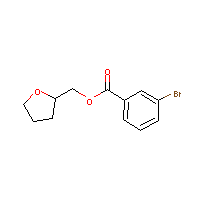

In [229]:
draw_mol_by_smiles('O=C(OCC1CCCO1)c1cccc(Br)c1')

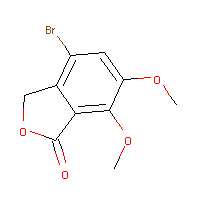

In [230]:
draw_mol_by_smiles('COc1cc(Br)c2c(c1OC)C(=O)OC2')

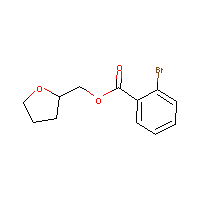

In [231]:
draw_mol_by_smiles('O=C(OCC1CCCO1)c1ccccc1Br')

In [233]:
o = get_minus_result(x_embedding=x_embedding2, x='O=c1c(O)c(-c2ccc(O)cc2)oc2ccccc12', y='O=c1c(O)c(-c2ccc(O)cc2)oc2cccc(O)c12')
o

array([[ 0.        , -4.5793076 ,  0.        , -0.3603382 , -0.23319244,
         0.47312403,  0.        ,  0.        ,  0.        ,  0.06194568,
        -0.40190792,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.8399906 ,  0.        ,  0.32900596,  0.        ,  0.10088366,
        -0.6174593 , -0.46787882,  0.        ,  0.        ,  0.09594807,
         0.        ,  0.1209743 , -0.07163858,  0.        ,  0.        ]],
      dtype=float32)

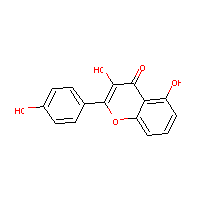

In [234]:
draw_mol_by_smiles('O=c1c(O)c(-c2ccc(O)cc2)oc2cccc(O)c12')

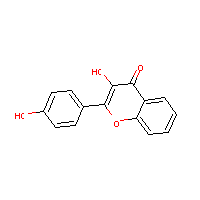

In [235]:
draw_mol_by_smiles('O=c1c(O)c(-c2ccc(O)cc2)oc2ccccc12')

In [236]:
print_closest_words(x_embedding=x_embedding2, x_query='Cc1ccc(-c2nc(C#N)c(N3CCCC3)o2)cc1', add_vec=o)

x is: [[ 0.        54.095474   0.         4.6700926  0.         0.
   0.6684832  6.496822   0.         0.        11.348324   0.
   0.         0.         0.3130484  7.0950704  0.         0.
   0.         0.         6.192023   0.         1.2921927  0.
   0.         0.         0.         0.         0.         0.       ]]
x + add_vec is: [[ 0.         49.516167    0.          4.3097544  -0.23319244  0.47312403
   0.6684832   6.496822    0.          0.06194568 10.946416    0.
   0.          0.          0.3130484   6.2550797   0.          0.32900596
   0.          0.10088366  5.5745635  -0.46787882  1.2921927   0.
   0.09594807  0.          0.1209743  -0.07163858  0.          0.        ]]
N#Cc1ccc(-n2ccnc2C2COCCN2)cc1 [1.6007155]
N#Cc1ccccc1-n1ccnc1C1COCCN1 [1.6007155]
N#Cc1cccc(-n2ccnc2C2COCCN2)c1 [1.6007155]
Cc1coc(-c2[nH]c(C3CCCCC3)nc2C#N)n1 [1.9068636]
Cc1cnc(-c2[nH]c(C3CCCCC3)nc2C#N)o1 [1.9068636]


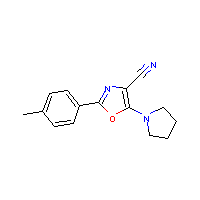

In [237]:
draw_mol_by_smiles('Cc1ccc(-c2nc(C#N)c(N3CCCC3)o2)cc1')

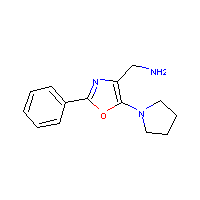

In [243]:
draw_mol_by_smiles('c1ccc(-c2nc(CN)c(N3CCCC3)o2)cc1')

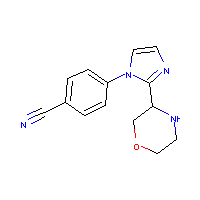

In [238]:
draw_mol_by_smiles('N#Cc1ccc(-n2ccnc2C2COCCN2)cc1')

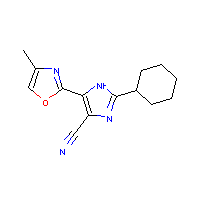

In [239]:
draw_mol_by_smiles('Cc1coc(-c2[nH]c(C3CCCCC3)nc2C#N)n1')

In [240]:
print_closest_words(x_embedding=x_embedding2, x_query='Cc1ccc(-c2nc(C#N)c(N3CCCC3)o2)cc1', add_vec=ch2)

x is: [[ 0.        54.095474   0.         4.6700926  0.         0.
   0.6684832  6.496822   0.         0.        11.348324   0.
   0.         0.         0.3130484  7.0950704  0.         0.
   0.         0.         6.192023   0.         1.2921927  0.
   0.         0.         0.         0.         0.         0.       ]]
x + add_vec is: [[ 0.0000000e+00  5.5605713e+01 -1.2183534e-01  4.6377897e+00
   1.8062019e-01  9.4491512e-01  3.5271186e-01  6.4968219e+00
  -3.2957083e-01  7.1452665e-01  1.1867239e+01  0.0000000e+00
   0.0000000e+00  0.0000000e+00  3.1304839e-01  7.6524882e+00
   0.0000000e+00  4.6140313e-01  0.0000000e+00 -2.0152640e-01
   6.1093583e+00  4.2657948e-01  1.2921927e+00  0.0000000e+00
   1.8944024e-01  0.0000000e+00  4.3624997e-01 -3.4246922e-02
   0.0000000e+00 -5.6854725e-02]]
N#Cc1nc(-c2cccnc2)oc1NC1CCCC1 [1.8229408]
N#Cc1nnc2ccccc2c1NCC1CCCO1 [2.0215893]
COCc1[nH]c(-c2ccc3c(c2)CCC3)nc1C#N [2.2516892]
Cc1cccc(-c2nc(C#N)c(N3CCOCC3)o2)c1 [2.2627244]
N#Cc1nc(Cc2ccccc2)oc1

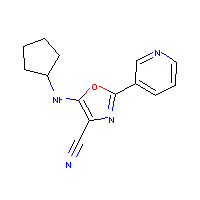

In [241]:
draw_mol_by_smiles('N#Cc1nc(-c2cccnc2)oc1NC1CCCC1')

##### similarity in fragment embedding

In [252]:
print_closest_words(x_embedding=frag2vec, x_query='CC')

CN [2.07466464]
C1=CCCC=CC1 [2.14207096]
C1=CCCCC=C1 [2.16296164]
C1CCCC1 [2.31532599]
C1=CCC=NC=C1 [2.32695495]


In [253]:
print_closest_words(x_embedding=frag_embedding_df, x_query='CC')

C [1.5646602]
CN [2.7478273]
N [2.8887343]
CBr [3.3683567]
CO [3.4576266]


In [267]:
print_closest_words(x_embedding=frag_embedding_df, x_query='CO')

OBr [2.0014253]
N [2.683726]
C [3.167312]
CF [3.335624]
CN [3.4302983]


In [268]:
print_closest_words(x_embedding=frag2vec, x_query='CC')

CN [2.07466464]
C1=CCCC=CC1 [2.14207096]
C1=CCCCC=C1 [2.16296164]
C1CCCC1 [2.31532599]
C1=CCC=NC=C1 [2.32695495]


In [254]:
print_closest_words(x_embedding=frag_embedding_df, x_query='C=C')

C=O [5.002908]
C1=CC=CC=C1 [5.4707036]
C1=CNCN1 [6.1134224]
C1=NC=NC=N1 [6.3348575]
C1=CCC1 [6.4296627]


In [258]:
double_bond = get_minus_result(x_embedding=frag_embedding_df, x='C=C', y='CC')
double_bond

array([[ 0.36769712,  9.422612  , -0.48457044,  1.1551089 ,  1.5239681 ,
         0.8708347 , -1.2110605 , -0.04955075,  1.1479666 ,  0.87259626,
         3.7456775 ,  0.        ,  0.8183497 ,  2.1820397 ,  0.4321878 ,
         2.4031503 , -0.48953053,  2.6529222 ,  0.        ,  0.845729  ,
         0.65948963, -0.5821216 ,  0.12837031, -0.45342237,  0.09806375,
        -0.27701962,  0.21591023,  0.5738481 , -0.8989567 ,  1.4418697 ]],
      dtype=float32)

In [264]:
double_bond2 = get_minus_result(x_embedding=frag_embedding_df, x='C=O', y='CO')
double_bond2

array([[ 4.0723282e-01,  6.6590004e+00, -1.2108864e+00,  2.3326802e-01,
         1.6675756e+00,  1.3117418e+00, -1.0975618e+00, -8.3342284e-02,
         2.0483384e+00,  1.4814731e-01,  2.3806596e+00,  0.0000000e+00,
         6.4973027e-01,  1.1030102e+00, -4.0664947e-01,  2.5701227e+00,
         4.9589813e-02,  2.0444705e+00,  1.9256592e-02,  1.0507717e+00,
        -3.7434539e-01,  8.6723781e-01, -5.3390515e-01,  0.0000000e+00,
         5.4839289e-01, -1.6959384e-04,  1.7381706e+00,  9.9883437e-01,
        -5.3652120e-01,  2.4301732e-01]], dtype=float32)

In [271]:
double_bond3 = get_minus_result(x_embedding=frag_embedding_df, x='C=S', y='CS')
double_bond3

array([[-0.4695816 ,  1.8891354 , -1.2449311 ,  0.36235547,  0.9577973 ,
         1.3812841 , -0.15191785, -0.23708494,  0.        , -0.95158863,
         0.16325235,  0.        ,  0.5461434 ,  0.3075782 , -1.2855554 ,
         1.0543567 ,  0.08943334,  1.4867198 , -0.00479811,  1.7650702 ,
        -0.4521917 ,  1.1224887 , -0.4057414 , -0.03514176,  0.39405894,
         0.12321979,  2.0169082 ,  0.8386388 ,  0.5432226 ,  1.225359  ]],
      dtype=float32)

In [272]:
double_bond4 = get_minus_result(x_embedding=frag_embedding_df, x='C=N', y='CN')
double_bond4

array([[ 0.15281081, 11.585732  , -0.01719204,  1.0333048 ,  3.6279893 ,
         3.4798925 , -0.98005795,  0.5539837 ,  1.5436594 , -0.12800089,
         5.1554136 ,  0.        ,  2.3757029 ,  1.6630778 , -0.456348  ,
         2.580281  ,  1.4344052 ,  1.5856826 ,  1.6862209 ,  2.638512  ,
         0.        ,  0.6221771 , -0.45990312,  1.3802598 ,  0.68077755,
         0.7403398 ,  0.75010884,  0.        , -0.2682166 ,  2.8274286 ]],
      dtype=float32)

In [280]:
double_bond_mean = np.concatenate((double_bond, double_bond2, double_bond3, double_bond4)).mean(axis=0)
double_bond_mean

array([ 0.11453979,  7.38912   , -0.73939496,  0.6960093 ,  1.9443325 ,
        1.7609384 , -0.86014956,  0.04600143,  1.1849911 , -0.01471148,
        2.8612509 ,  0.        ,  1.0974816 ,  1.3139265 , -0.42909127,
        2.1519778 ,  0.27097446,  1.9424489 ,  0.42516983,  1.5750208 ,
       -0.04176187,  0.5074455 , -0.31779483,  0.2229239 ,  0.4303233 ,
        0.14659259,  1.1802745 ,  0.6028303 , -0.29011798,  1.4344187 ],
      dtype=float32)

In [261]:
cal_distance(double_bond, double_bound2)

array([[4.8198957]], dtype=float32)

In [281]:
print_closest_words(x_embedding=frag_embedding_df, x_query='CC', add_vec=double_bond_mean)

C=C [3.808685]
C=O [4.0065684]
C=S [4.4869885]
C1=CC=CC=C1 [5.1712956]
C1=NC=NC=N1 [5.7014313]


In [282]:
print_closest_words(x_embedding=frag_embedding_df, x_query='CO', add_vec=double_bond_mean)

C=O [2.3767626]
C=C [4.2255626]
O=S [4.367085]
C1=CN=CC1 [4.541905]
C1=NCCN=C1 [4.861382]


In [289]:
print_closest_words(x_embedding=frag_embedding_df, x_query='CS')

CF [3.2992227]
CCl [3.6188667]
OBr [3.7171252]
N [3.8763359]
CO [3.902422]


In [295]:
print_closest_words(x_embedding=frag_embedding_df, x_query='OS', add_vec=double_bond_mean)

C=N [8.806425]
NN [9.520893]
OS [9.572178]
C1NCNN1 [9.702293]
C1=CSCC1 [10.3120985]
